TODO: 
- split cell intern  matrices

In [21]:
import argparse
import torch
from torch.autograd import Variable
from torch import nn
from seq2seq.util.checkpoint import Checkpoint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy
from mpl_toolkits.axes_grid1 import AxesGrid

In [22]:
class Model(object):
    def __init__(self, model):
        self.model = model
        params = {}
        for name, param in self.model.named_parameters():
            param = param.data.numpy()
            params[name]=pd.DataFrame(param)
        self.params = params
        
    def get_param_names(self):
        return [name for name, _ in self.model.named_parameters()]

    def get_modules(self):
        return [mod for mod in self.model.modules()]

    def get_param_by_name(self, name):
        return pd.DataFrame(self.params[name])

    def heatmap(self):
        return {k: sns.heatmap(v) for k, v in self.params.items()}

    def apply_mean(self):
        return {k: np.ravel(v).mean() if v.shape != (1,1) else np.NaN for k, v in self.params.items()}
       
    def apply_std(self):
        return {k: np.ravel(v).std() if v.shape != (1,1) else np.NaN for k, v in self.params.items()}
    
    def apply_min(self):
        return {k: np.ravel(v).min() for k, v in self.params.items()}
    
    def apply_max(self):
        return {k: np.ravel(v).max() for k, v in self.params.items()}
        
    def apply_norm(self):
        return {k: np.linalg.norm(np.ravel(v)) if v.shape != (1,1) else np.NaN for k, v in self.params.items()}
            
    def param_to_dist(self,name):
        data = self.params[name]
        data = np.ravel(data)
#         # best fit of data
#         (mu, sigma) = norm.fit(data)

#         # the histogram of the data
#         n, bins, patches = plt.hist(data, 20, normed=1)

#         # add a 'best fit' line
#         y = mlab.normpdf( bins, mu, sigma)
#         l = plt.plot(bins, y, 'r--', linewidth=2)
#        return scipy.stats.norm(mu, sigma)
        return np.histogram(data, bins=50, range=[-1, 1], density=True)
        

            
class Models(object):
    def mean_of(self, data):
        one_key = list(data.keys())[0]
        return {param: np.mean([data[name][param] for name in data.keys()]) for param in data[one_key].keys()}
    
    def load_models(self):
        models = {}
        files = os.listdir(self.model_path)
        for file in files: 
            if not file.startswith('.'):
                print('loading: ', self.model_path + '/' + file)
                checkpoint = Checkpoint.load(self.model_path + '/' + file)
                seq2seq = checkpoint.model
                models[file] = Model(seq2seq)
        return models
    
    def __init__(self, model_path,title):
        
        self.image_folder = 'images/'
        self.title = title
        self.model_path = model_path
        
        self.models = self.load_models()

        ## calculate mean, std, norm
        self.means = {name: model.apply_mean() for name,model in self.models.items()}
        self.stds = {name : model.apply_std() for name,model in self.models.items()}
        self.norms = {name: model.apply_norm() for name, model in self.models.items()}
        self.mins = {name: model.apply_min() for name, model in self.models.items()}
        self.maxs = {name: model.apply_max() for name, model in self.models.items()}
        
        ## caluclate mean of means, stds, norms
        self.mean_of_means = self.mean_of(self.means)
        self.mean_of_stds = self.mean_of(self.stds)
        self.mean_of_norms = self.mean_of(self.norms) 
        self.maxs = self.mean_of(self.maxs) 
        self.mins = self.mean_of(self.mins) 
        
        # fill data into df 
        df = pd.DataFrame.from_dict(self.mean_of_means,  orient='index')
        df = df.rename(columns={0: 'mean of means'})
        df['mean of stds'] = self.mean_of_stds.values()
        df['mean of norms'] = self.mean_of_norms.values()
        df['mean of maxs'] = self.maxs.values()
        df['mean of mins'] = self.mins.values()
        self.stats = df       
        
    
    def apply_heatmap(self):
        for model_name, model in self.models.items():
            for param_name in self.models[model_name].params.keys():
                plt.figure()
                sns.heatmap(model.params[param_name])
                plt.title(self.title + ' (' + model_name + ') - \n heatmap of param: ' + param_name)
                plt.savefig(self.image_folder +'heatmap/'+ self.title + '_' + model_name + '_' + param_name + '.png', dpi=300)
                plt.show()
                
    def apply_heatmap_by_name(self,param_name):
        for model_name, model in self.models.items():
            plt.figure()
            sns.heatmap(model.params[param_name])
            plt.title(self.title + ' (' + model_name + ') - \n heatmap of param: ' + param_name)
            plt.savefig(self.image_folder+'heatmap/' + self.title + '_' + model_name + '_' + param_name + '.png', dpi=300)
            plt.show()    

In [23]:
guided_gru = Models('../machine-zoo/guided/gru', 'Guided_GRU')
baseline_gru = Models('../machine-zoo/baseline/gru', 'Baseline_GRU')

guided_lstm = Models('../machine-zoo/guided/lstm', 'Guided_LSTM')
baseline_lstm = Models('../machine-zoo/baseline/lstm', 'Baseline_LSTM')

loading:  ../machine-zoo/guided/gru/1
loading:  ../machine-zoo/guided/gru/2
loading:  ../machine-zoo/guided/gru/3
loading:  ../machine-zoo/guided/gru/4
loading:  ../machine-zoo/guided/gru/5
loading:  ../machine-zoo/baseline/gru/1
loading:  ../machine-zoo/baseline/gru/2
loading:  ../machine-zoo/baseline/gru/3
loading:  ../machine-zoo/baseline/gru/4
loading:  ../machine-zoo/baseline/gru/5
loading:  ../machine-zoo/guided/lstm/1
loading:  ../machine-zoo/guided/lstm/2
loading:  ../machine-zoo/guided/lstm/3
loading:  ../machine-zoo/guided/lstm/4
loading:  ../machine-zoo/guided/lstm/5
loading:  ../machine-zoo/baseline/lstm/1
loading:  ../machine-zoo/baseline/lstm/2
loading:  ../machine-zoo/baseline/lstm/3
loading:  ../machine-zoo/baseline/lstm/4
loading:  ../machine-zoo/baseline/lstm/5


### Sizes of layers

In [24]:
for name, params in guided_lstm.models['1'].params.items():
    print(params.shape, name)

(19, 16) encoder.embedding.weight
(2048, 16) encoder.rnn.weight_ih_l0
(2048, 512) encoder.rnn.weight_hh_l0
(2048, 1) encoder.rnn.bias_ih_l0
(2048, 1) encoder.rnn.bias_hh_l0
(2048, 512) decoder.rnn.weight_ih_l0
(2048, 512) decoder.rnn.weight_hh_l0
(2048, 1) decoder.rnn.bias_ih_l0
(2048, 1) decoder.rnn.bias_hh_l0
(11, 512) decoder.embedding.weight
(512, 1024) decoder.attention.method.mlp.weight
(512, 1) decoder.attention.method.mlp.bias
(1, 512) decoder.attention.method.out.weight
(1, 1) decoder.attention.method.out.bias
(11, 512) decoder.out.weight
(11, 1) decoder.out.bias
(512, 1024) decoder.ffocus_merge.weight
(512, 1) decoder.ffocus_merge.bias


## Statistical Analysis

Baseline GRU

In [25]:
baseline_gru.stats

,mean of means,mean of stds,mean of norms,mean of maxs,mean of mins
encoder.embedding.weight,-1.759272e-03,0.146639,2.557299,0.466294,-0.440219
encoder.rnn.weight_ih_l0,1.795653e-03,0.132039,20.707676,0.657196,-0.636781
encoder.rnn.weight_hh_l0,2.041644e-04,0.088030,78.066849,0.566109,-0.596124
encoder.rnn.bias_ih_l0,-1.620729e-02,0.092863,3.695691,0.276811,-0.357539
encoder.rnn.bias_hh_l0,-1.591059e-02,0.092919,3.696127,0.273887,-0.335439
decoder.rnn.weight_ih_l0,-1.277724e-04,0.068788,61.002495,0.457143,-0.430959
decoder.rnn.weight_hh_l0,-1.709472e-04,0.075933,67.339149,0.425063,-0.432390
decoder.rnn.bias_ih_l0,-2.985862e-02,0.075753,3.191333,0.192314,-0.249801
decoder.rnn.bias_hh_l0,-2.878932e-02,0.075507,3.167907,0.207104,-0.249486
decoder.embedding.weight,-6.870941e-05,0.084614,6.350204,0.323575,-0.334121


Guided GRU

In [26]:
guided_gru.stats

,mean of means,mean of stds,mean of norms,mean of maxs,mean of mins
encoder.embedding.weight,-0.000959,0.139349,2.429867,0.376077,-0.403524
encoder.rnn.weight_ih_l0,-0.000206,0.080538,12.626729,0.542031,-0.511061
encoder.rnn.weight_hh_l0,0.000058,0.065287,57.897675,0.412640,-0.394051
encoder.rnn.bias_ih_l0,-0.012083,0.072939,2.898563,0.176322,-0.312060
encoder.rnn.bias_hh_l0,-0.013354,0.070808,2.824670,0.194362,-0.297983
decoder.rnn.weight_ih_l0,0.000041,0.065539,58.121387,0.742477,-0.713911
decoder.rnn.weight_hh_l0,-0.000056,0.058843,52.185558,0.291974,-0.281988
decoder.rnn.bias_ih_l0,-0.025098,0.059747,2.540183,0.144791,-0.195006
decoder.rnn.bias_hh_l0,-0.025394,0.059537,2.536941,0.131834,-0.197489
decoder.embedding.weight,0.000316,0.147676,11.082689,0.395972,-0.391510


Difference Guided GRU vs. Baseline GRU

In [27]:
guided_gru.stats-baseline_gru.stats

,mean of means,mean of stds,mean of norms,mean of maxs,mean of mins
encoder.embedding.weight,0.000801,-0.007290,-0.127432,-0.090217,0.036695
encoder.rnn.weight_ih_l0,-0.002002,-0.051502,-8.080947,-0.115165,0.125721
encoder.rnn.weight_hh_l0,-0.000147,-0.022743,-20.169174,-0.153468,0.202073
encoder.rnn.bias_ih_l0,0.004124,-0.019924,-0.797127,-0.100488,0.045480
encoder.rnn.bias_hh_l0,0.002557,-0.022111,-0.871457,-0.079525,0.037456
decoder.rnn.weight_ih_l0,0.000169,-0.003249,-2.881107,0.285334,-0.282951
decoder.rnn.weight_hh_l0,0.000115,-0.017090,-15.153591,-0.133089,0.150402
decoder.rnn.bias_ih_l0,0.004761,-0.016006,-0.651150,-0.047523,0.054795
decoder.rnn.bias_hh_l0,0.003395,-0.015970,-0.630966,-0.075270,0.051997
decoder.embedding.weight,0.000385,0.063062,4.732485,0.072397,-0.057389


Baseline LSTM

In [28]:
baseline_lstm.stats

,mean of means,mean of stds,mean of norms,mean of maxs,mean of mins
encoder.embedding.weight,-0.001442,0.162086,2.826329,0.492238,-0.502056
encoder.rnn.weight_ih_l0,0.000913,0.146842,26.588650,0.684907,-0.707094
encoder.rnn.weight_hh_l0,-0.000176,0.089515,91.664444,0.570511,-0.610069
encoder.rnn.bias_ih_l0,-0.037526,0.090355,4.483636,0.339953,-0.328324
encoder.rnn.bias_hh_l0,-0.038465,0.090417,4.501397,0.307354,-0.318395
decoder.rnn.weight_ih_l0,-0.000139,0.080955,82.899498,0.517021,-0.515518
decoder.rnn.weight_hh_l0,-0.000294,0.084335,86.370056,0.489893,-0.495761
decoder.rnn.bias_ih_l0,-0.035166,0.065420,3.369680,0.178394,-0.243665
decoder.rnn.bias_hh_l0,-0.033474,0.065755,3.347765,0.171613,-0.239341
decoder.embedding.weight,-0.000122,0.132717,9.960362,0.474859,-0.472432


Guided LSTM

In [29]:
guided_lstm.stats

,mean of means,mean of stds,mean of norms,mean of maxs,mean of mins
encoder.embedding.weight,0.002058,0.179018,3.123551,0.543385,-0.524266
encoder.rnn.weight_ih_l0,0.000245,0.113211,20.516216,0.710162,-0.710747
encoder.rnn.weight_hh_l0,0.000026,0.071164,72.872803,0.551239,-0.668254
encoder.rnn.bias_ih_l0,-0.010346,0.082105,3.746127,0.408405,-0.251434
encoder.rnn.bias_hh_l0,-0.010515,0.081048,3.700511,0.403438,-0.238568
decoder.rnn.weight_ih_l0,0.000095,0.080769,82.708237,0.941351,-0.865073
decoder.rnn.weight_hh_l0,-0.000130,0.073191,74.948914,0.402468,-0.391413
decoder.rnn.bias_ih_l0,-0.024615,0.059836,2.930603,0.152430,-0.214242
decoder.rnn.bias_hh_l0,-0.024132,0.060696,2.957357,0.167402,-0.216230
decoder.embedding.weight,0.000231,0.179740,13.489433,0.491869,-0.492699


In [30]:
guided_lstm.stats-baseline_lstm.stats

,mean of means,mean of stds,mean of norms,mean of maxs,mean of mins
encoder.embedding.weight,0.003499,0.016932,0.297222,0.051147,-0.022210
encoder.rnn.weight_ih_l0,-0.000668,-0.033631,-6.072433,0.025255,-0.003653
encoder.rnn.weight_hh_l0,0.000202,-0.018351,-18.791641,-0.019272,-0.058185
encoder.rnn.bias_ih_l0,0.027180,-0.008251,-0.737509,0.068452,0.076890
encoder.rnn.bias_hh_l0,0.027949,-0.009369,-0.800885,0.096084,0.079827
decoder.rnn.weight_ih_l0,0.000234,-0.000186,-0.191261,0.424330,-0.349556
decoder.rnn.weight_hh_l0,0.000164,-0.011144,-11.421143,-0.087425,0.104349
decoder.rnn.bias_ih_l0,0.010551,-0.005584,-0.439077,-0.025964,0.029423
decoder.rnn.bias_hh_l0,0.009341,-0.005059,-0.390408,-0.004212,0.023111
decoder.embedding.weight,0.000354,0.047023,3.529071,0.017010,-0.020267


In [38]:
class Analysis(object):
    
    def intersection(self, hist_1, hist_2):
        minima = np.minimum(hist_1, hist_2)
        intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
        return intersection
    
    def bhattacharyya(self, h1, h2):
      '''Calculates the Byattacharyya distance of two histograms.'''
      def normalize(h):
        return h / np.sum(h)
      return 1 - np.sum(np.sqrt(np.multiply(normalize(h1), normalize(h2))))

    def KL(self,dist_1, dist_2):
        x = np.linspace(-1, 1, 100)
        return scipy.stats.entropy(dist_1.pdf(x),dist_2.pdf(x))  
    
    def compare_distributions(self):
        dist = {}
        for model_name_base in self.models_baseline.keys():
            for model_name_guided in self.models_guided.keys():
                per_model = {}
                for param in self.models_baseline[list(self.models_baseline.keys())[0]].params.keys():
                    if not self.models_baseline[model_name_base].params[param].shape == (1,1):
                        dist_1, _ = self.models_baseline[model_name_base].param_to_dist(param)
                        dist_2, _ = self.models_guided[model_name_guided].param_to_dist(param)
                        per_model[param] = self.bhattacharyya(dist_1, dist_2)
                key = model_name_base + '_' + model_name_guided
                dist[key] = per_model
        return pd.DataFrame.from_dict(dist, orient='index')
    
    def compare_dist_within(self, models):
        dist = {}
        for param in models[list(models.keys())[0]].params.keys():
            within_model = {}
            for model_name_base in models.keys():
                for model_name_guided in models.keys():
                    if (model_name_base != model_name_guided) and (not models[model_name_base].params[param].shape == (1,1)):
                        dist_1,_ = models[model_name_base].param_to_dist(param)
                        dist_2,_ = models[model_name_guided].param_to_dist(param)
                        key = model_name_base + '_' + model_name_guided
                        within_model[key] = self.bhattacharyya(dist_1, dist_2)
                dist[param] = within_model
        return pd.DataFrame.from_dict(dist, orient='index')
    
    def __init__(self, models_baseline, models_guided):
        self.models_baseline = models_baseline.models
        self.models_guided = models_guided.models
        self.title_baseline = models_baseline.title
        self.title_guided = models_guided.title
        self.image_path = 'images/'
        self.dist = self.compare_distributions()
        self.dist_within_baseline = self.compare_dist_within(self.models_baseline)
        self.dist_within_guided = self.compare_dist_within(self.models_guided)
        
    def compare_dist_by_name(self,param):
        dist = {}
        for model_name in self.models_baseline.keys():
            assert(self.models_baseline[model_name].params[param].shape != (1,1))
            dist_1 = self.models_baseline[model_name].param_to_dist(param)
            dist_2 = self.models_guided[model_name].param_to_dist(param)
            dist[param] = self.bhattacharyya(dist_1, dist_2)
        return dist
    
    def plot_dist(self,param):
        plt.figure(figsize=(12,30))
        for i in range(1,6):
            plt.subplot(5,1,i)
            plt.title(param + ' ' + str(i))
            plt.hist(np.ravel(self.models_baseline[str(i)].params[param]), bins=50,range=[-1, 1], density=True, alpha=0.4, label=self.title_baseline)
            plt.hist(np.ravel(self.models_guided[str(i)].params[param]), bins=50,range=[-1, 1], density=True, alpha=0.4,label=self.title_guided)
            plt.legend()
        plt.savefig(self.image_path+ 'distributions/hist_' + self.title_baseline + '_'+ param +'.png', dpi=300 )
        plt.show()

## Analysis of Distribution of parameters

GRU Guided vs. Baseline

In [42]:
analysis_GRU = Analysis(baseline_gru, guided_gru)

In [43]:
analysis_GRU.dist.describe()

,encoder.embedding.weight,encoder.rnn.weight_ih_l0,encoder.rnn.weight_hh_l0,encoder.rnn.bias_ih_l0,encoder.rnn.bias_hh_l0,decoder.rnn.weight_ih_l0,decoder.rnn.weight_hh_l0,decoder.rnn.bias_ih_l0,decoder.rnn.bias_hh_l0,decoder.embedding.weight,decoder.attention.method.mlp.weight,decoder.attention.method.mlp.bias,decoder.attention.method.out.weight,decoder.out.weight,decoder.out.bias,decoder.ffocus_merge.weight,decoder.ffocus_merge.bias
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.026962,0.054039,0.018751,0.023774,0.024031,0.004318,0.017141,0.022005,0.022358,0.144196,0.003944,0.026716,0.163405,0.006673,0.226584,0.003529,0.065600
std,0.006883,0.007592,0.005171,0.008857,0.009013,0.001280,0.004911,0.004817,0.005049,0.020873,0.001800,0.011517,0.077649,0.001342,0.104783,0.000836,0.015539
min,0.014697,0.043359,0.009857,0.008913,0.006805,0.002442,0.009005,0.011795,0.014147,0.100738,0.001455,0.009376,0.055881,0.004640,0.062437,0.002503,0.034132
25%,0.021944,0.048138,0.015683,0.019482,0.020831,0.003196,0.013220,0.018948,0.019000,0.129204,0.002591,0.019160,0.103389,0.005690,0.153346,0.002912,0.058410
50%,0.026650,0.052673,0.017698,0.022708,0.025128,0.004298,0.016588,0.022855,0.022191,0.145619,0.003959,0.023998,0.143982,0.006460,0.215361,0.003112,0.069951
75%,0.031351,0.058305,0.020957,0.032051,0.031026,0.005221,0.021327,0.024096,0.024289,0.160977,0.004745,0.035717,0.230180,0.008099,0.275028,0.004141,0.076677
max,0.039930,0.072372,0.030134,0.038213,0.036865,0.006864,0.027380,0.030869,0.033411,0.177740,0.008196,0.052023,0.312853,0.008942,0.466936,0.005445,0.092644


GRU distribution within Baseline

In [45]:
analysis_GRU.dist_within_baseline.T.describe()

,decoder.attention.method.mlp.bias,decoder.attention.method.mlp.weight,decoder.attention.method.out.weight,decoder.embedding.weight,decoder.ffocus_merge.bias,decoder.ffocus_merge.weight,decoder.out.bias,decoder.out.weight,decoder.rnn.bias_hh_l0,decoder.rnn.bias_ih_l0,decoder.rnn.weight_hh_l0,decoder.rnn.weight_ih_l0,encoder.embedding.weight,encoder.rnn.bias_hh_l0,encoder.rnn.bias_ih_l0,encoder.rnn.weight_hh_l0,encoder.rnn.weight_ih_l0
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.012520,0.001064,0.045398,0.007335,0.009171,0.000723,0.258963,0.001741,0.002973,0.002954,0.000256,0.000426,0.026481,0.005864,0.005234,0.000737,0.001135
std,0.006305,0.001193,0.018694,0.006087,0.004623,0.000528,0.099339,0.000612,0.000896,0.001354,0.000208,0.000334,0.010418,0.003186,0.002651,0.000765,0.000596
min,0.005251,0.000011,0.016728,0.000797,0.004225,0.000027,0.086796,0.000886,0.001442,0.001006,0.000023,0.000044,0.011640,0.002586,0.001514,0.000066,0.000292
25%,0.006489,0.000021,0.033240,0.002693,0.005306,0.000263,0.206177,0.001419,0.002411,0.001887,0.000041,0.000079,0.019631,0.003331,0.003468,0.000151,0.000718
50%,0.011030,0.000610,0.045275,0.004495,0.007995,0.000694,0.309477,0.001613,0.003162,0.002893,0.000264,0.000416,0.025662,0.004906,0.005254,0.000465,0.000918
75%,0.018703,0.001676,0.054834,0.010171,0.012940,0.001211,0.338371,0.001907,0.003842,0.003792,0.000432,0.000715,0.034010,0.006759,0.006439,0.001136,0.001855
max,0.022833,0.003987,0.076066,0.021125,0.017482,0.001513,0.350340,0.003075,0.004044,0.005870,0.000627,0.000951,0.047131,0.011440,0.010076,0.002526,0.001881


GRU distribution within Guided

In [46]:
analysis_GRU.dist_within_guided.T.describe()

,decoder.attention.method.mlp.bias,decoder.attention.method.mlp.weight,decoder.attention.method.out.weight,decoder.embedding.weight,decoder.ffocus_merge.bias,decoder.ffocus_merge.weight,decoder.out.bias,decoder.out.weight,decoder.rnn.bias_hh_l0,decoder.rnn.bias_ih_l0,decoder.rnn.weight_hh_l0,decoder.rnn.weight_ih_l0,encoder.embedding.weight,encoder.rnn.bias_hh_l0,encoder.rnn.bias_ih_l0,encoder.rnn.weight_hh_l0,encoder.rnn.weight_ih_l0
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.008622,0.000205,0.038002,0.002338,0.006346,0.000152,0.209895,0.000946,0.001259,0.002290,0.000736,0.000117,0.019152,0.002064,0.002029,0.000256,0.000738
std,0.003000,0.000113,0.012795,0.001105,0.002349,0.000119,0.113436,0.000343,0.000930,0.000926,0.000682,0.000055,0.004871,0.000705,0.000716,0.000262,0.000267
min,0.004982,0.000083,0.025442,0.001108,0.002466,0.000043,0.053253,0.000453,0.000284,0.000830,0.000108,0.000042,0.011594,0.001248,0.001228,0.000012,0.000418
25%,0.006092,0.000130,0.029122,0.001194,0.004955,0.000068,0.105600,0.000802,0.000565,0.001951,0.000311,0.000092,0.015975,0.001735,0.001419,0.000054,0.000523
50%,0.007865,0.000168,0.033085,0.002292,0.006176,0.000133,0.206210,0.000903,0.001200,0.002208,0.000375,0.000099,0.019659,0.001924,0.001828,0.000107,0.000657
75%,0.011501,0.000258,0.049216,0.002861,0.007836,0.000178,0.280583,0.001059,0.001555,0.003049,0.001066,0.000160,0.024558,0.002157,0.002614,0.000387,0.000909
max,0.013584,0.000477,0.064976,0.004526,0.010691,0.000468,0.426073,0.001723,0.003614,0.003701,0.002373,0.000203,0.024857,0.003658,0.003434,0.000823,0.001198


LSTM Guided vs. Baseline

In [47]:
analysis_LSTM = Analysis(guided_lstm, baseline_lstm)

In [48]:
analysis_LSTM.dist.describe()

,encoder.embedding.weight,encoder.rnn.weight_ih_l0,encoder.rnn.weight_hh_l0,encoder.rnn.bias_ih_l0,encoder.rnn.bias_hh_l0,decoder.rnn.weight_ih_l0,decoder.rnn.weight_hh_l0,decoder.rnn.bias_ih_l0,decoder.rnn.bias_hh_l0,decoder.embedding.weight,decoder.attention.method.mlp.weight,decoder.attention.method.mlp.bias,decoder.attention.method.out.weight,decoder.out.weight,decoder.out.bias,decoder.ffocus_merge.weight,decoder.ffocus_merge.bias
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.042542,0.026078,0.014499,0.032514,0.033509,0.003481,0.007441,0.010719,0.010120,0.112502,0.006228,0.030499,0.129791,0.011260,0.289671,0.007170,0.041611
std,0.015372,0.025101,0.014636,0.043101,0.043595,0.003319,0.010798,0.007536,0.007815,0.050187,0.007234,0.014684,0.076907,0.004905,0.095388,0.001475,0.010676
min,0.021189,0.001958,0.000128,0.002514,0.002415,0.000803,0.000031,0.002145,0.002516,0.029322,0.001256,0.011122,0.045948,0.003090,0.100093,0.004630,0.022714
25%,0.030278,0.008930,0.003748,0.008345,0.007795,0.001526,0.000803,0.004750,0.004136,0.081317,0.001823,0.019316,0.074646,0.007442,0.237970,0.006187,0.034173
50%,0.039643,0.014892,0.009621,0.011671,0.012798,0.002054,0.002831,0.007369,0.006772,0.118204,0.002471,0.027228,0.099234,0.011509,0.282596,0.007062,0.040615
75%,0.051733,0.042894,0.019299,0.027229,0.029543,0.003909,0.004993,0.014799,0.014462,0.146708,0.006352,0.037574,0.173908,0.014317,0.347133,0.007900,0.044392
max,0.076945,0.096665,0.049975,0.124547,0.130731,0.012448,0.033670,0.026435,0.027052,0.206808,0.025717,0.062472,0.288911,0.023074,0.491295,0.010923,0.063743


LSTM distribution within Baseline

In [49]:
analysis_LSTM.dist_within_baseline.T.describe()

,decoder.attention.method.mlp.bias,decoder.attention.method.mlp.weight,decoder.attention.method.out.weight,decoder.embedding.weight,decoder.ffocus_merge.bias,decoder.ffocus_merge.weight,decoder.out.bias,decoder.out.weight,decoder.rnn.bias_hh_l0,decoder.rnn.bias_ih_l0,decoder.rnn.weight_hh_l0,decoder.rnn.weight_ih_l0,encoder.embedding.weight,encoder.rnn.bias_hh_l0,encoder.rnn.bias_ih_l0,encoder.rnn.weight_hh_l0,encoder.rnn.weight_ih_l0
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.010108,0.000465,0.029924,0.011677,0.013972,0.000556,0.243327,0.004531,0.002100,0.002936,0.000612,0.000496,0.037628,0.003398,0.003697,0.000696,0.005371
std,0.006225,0.000383,0.006274,0.007653,0.004345,0.000347,0.099406,0.001646,0.001098,0.001102,0.000638,0.000469,0.011469,0.001138,0.001422,0.000670,0.003937
min,0.003537,0.000093,0.022725,0.002756,0.008300,0.000197,0.086796,0.002514,0.000895,0.001266,0.000019,0.000045,0.018052,0.001725,0.002383,0.000079,0.001408
25%,0.005051,0.000203,0.026464,0.004863,0.010764,0.000369,0.151174,0.002885,0.000978,0.002061,0.000189,0.000161,0.026692,0.002632,0.002566,0.000184,0.002783
50%,0.007664,0.000295,0.027839,0.009454,0.013157,0.000414,0.246798,0.004074,0.001875,0.002887,0.000410,0.000312,0.040139,0.003383,0.003109,0.000403,0.003769
75%,0.012429,0.000816,0.030583,0.017336,0.015566,0.000695,0.297931,0.006150,0.002875,0.003881,0.000652,0.000883,0.047937,0.004236,0.004430,0.001012,0.006682
max,0.021613,0.001280,0.041624,0.024517,0.022378,0.001401,0.441249,0.006979,0.004043,0.004548,0.002021,0.001539,0.053547,0.005486,0.006518,0.002230,0.013220


LSTM distribution within Guided

In [50]:
analysis_LSTM.dist_within_guided.T.describe()

,decoder.attention.method.mlp.bias,decoder.attention.method.mlp.weight,decoder.attention.method.out.weight,decoder.embedding.weight,decoder.ffocus_merge.bias,decoder.ffocus_merge.weight,decoder.out.bias,decoder.out.weight,decoder.rnn.bias_hh_l0,decoder.rnn.bias_ih_l0,decoder.rnn.weight_hh_l0,decoder.rnn.weight_ih_l0,encoder.embedding.weight,encoder.rnn.bias_hh_l0,encoder.rnn.bias_ih_l0,encoder.rnn.weight_hh_l0,encoder.rnn.weight_ih_l0
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.012057,0.008213,0.061076,0.039809,0.017000,0.004681,0.306266,0.013828,0.010883,0.010203,0.007839,0.005131,0.047229,0.043071,0.040148,0.010858,0.028230
std,0.004716,0.008540,0.046618,0.024906,0.006818,0.004347,0.116511,0.011677,0.009252,0.008507,0.008983,0.005486,0.014430,0.042211,0.041227,0.011054,0.026451
min,0.007121,0.000092,0.009339,0.014510,0.008584,0.000266,0.090003,0.003936,0.001329,0.001591,0.000036,0.000091,0.021306,0.004575,0.002762,0.000632,0.001808
25%,0.009148,0.000184,0.019646,0.018111,0.012283,0.001424,0.226001,0.004975,0.003008,0.003732,0.000333,0.000737,0.038579,0.007938,0.006202,0.004106,0.010744
50%,0.009650,0.005236,0.053747,0.035507,0.015588,0.003123,0.321804,0.006234,0.006905,0.008117,0.003175,0.002644,0.046124,0.019727,0.014603,0.006543,0.015851
75%,0.016437,0.019140,0.073555,0.054322,0.016980,0.007455,0.395429,0.024613,0.018645,0.013317,0.013269,0.010443,0.058298,0.080765,0.081387,0.016291,0.040534
max,0.020834,0.021701,0.144883,0.093848,0.031547,0.013824,0.483131,0.038296,0.029318,0.030335,0.028545,0.016626,0.070812,0.124558,0.111353,0.038455,0.092481


Plot interesting distributions of params

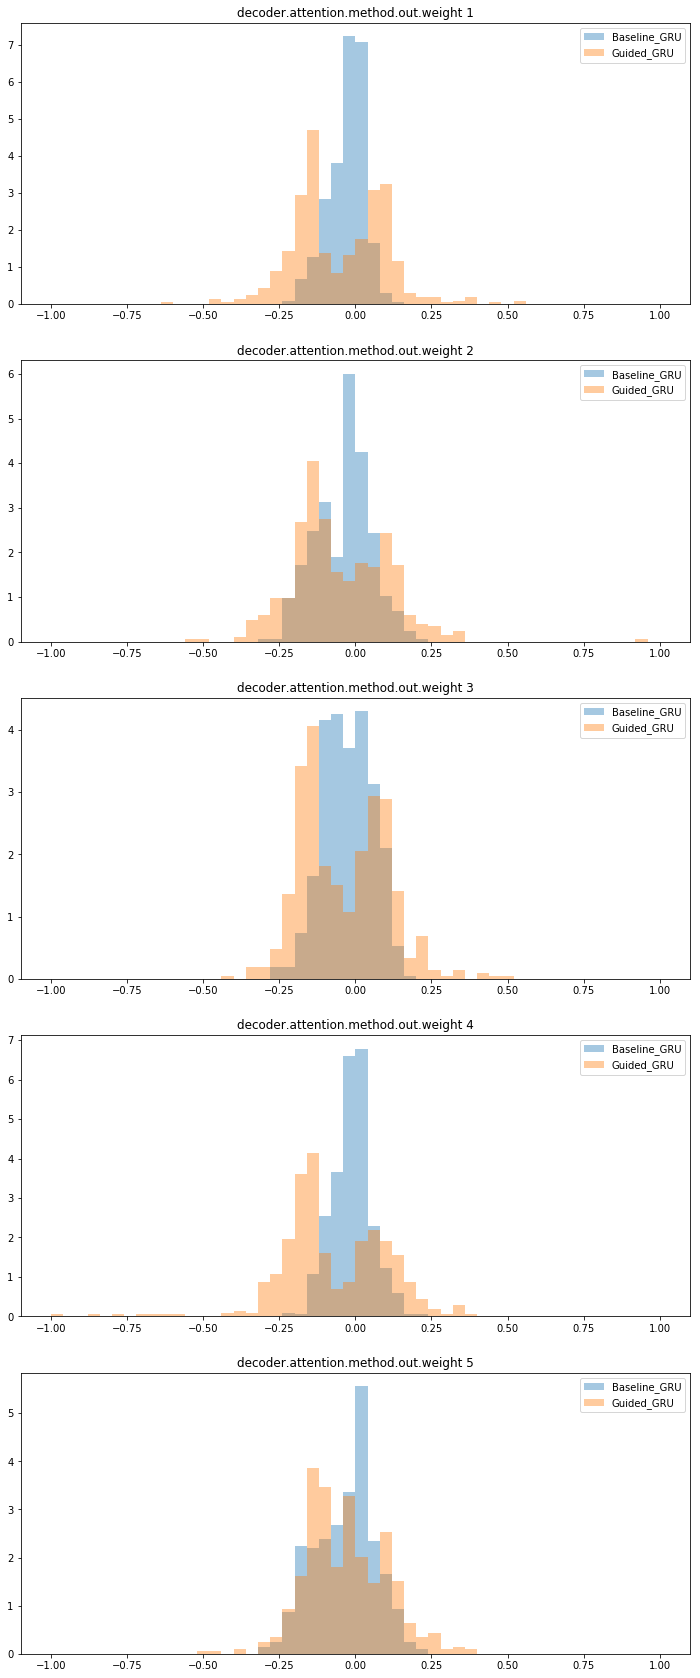

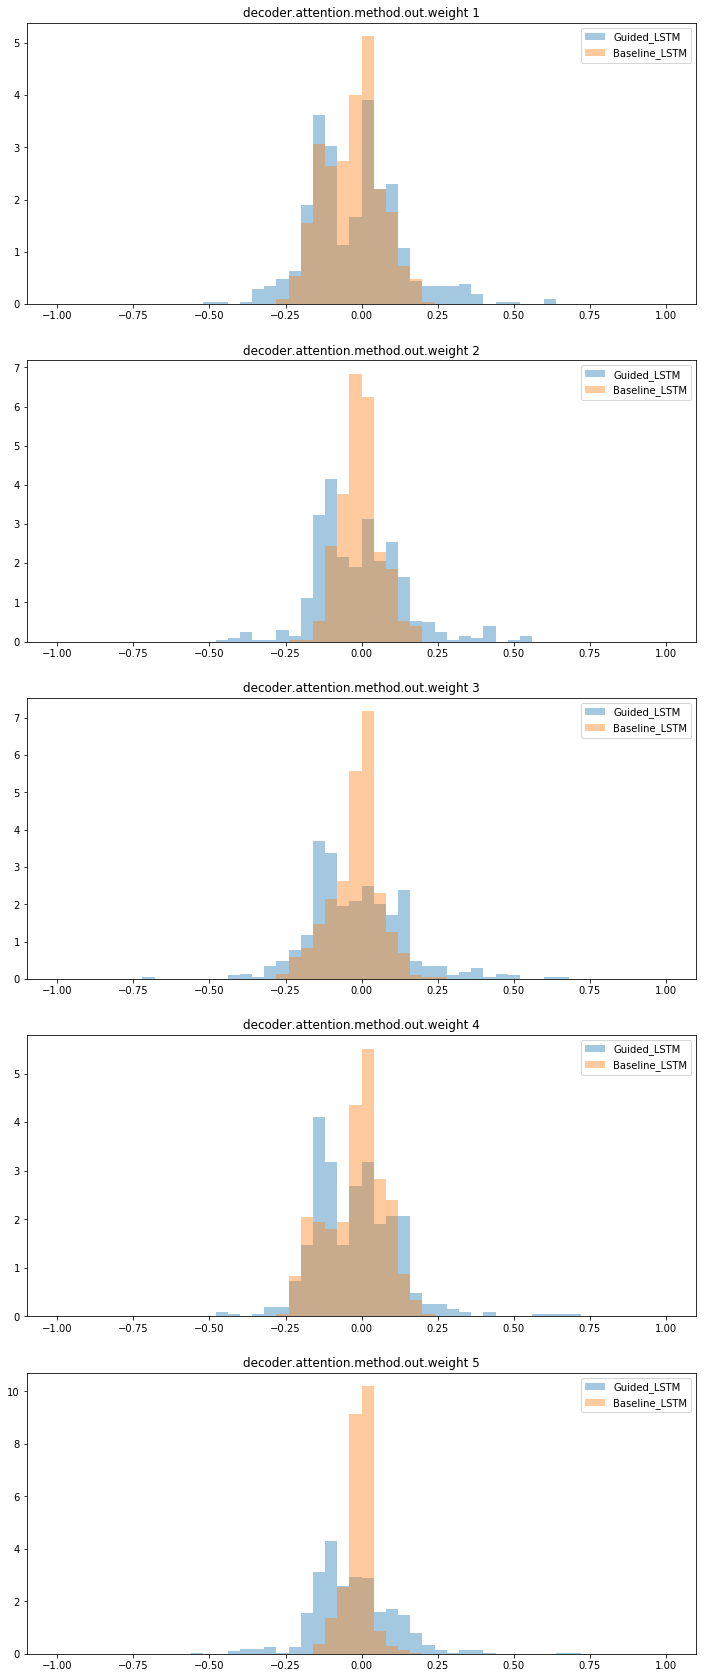

In [1650]:
analysis_GRU.plot_dist('decoder.attention.method.out.weight')
analysis_LSTM.plot_dist('decoder.attention.method.out.weight')

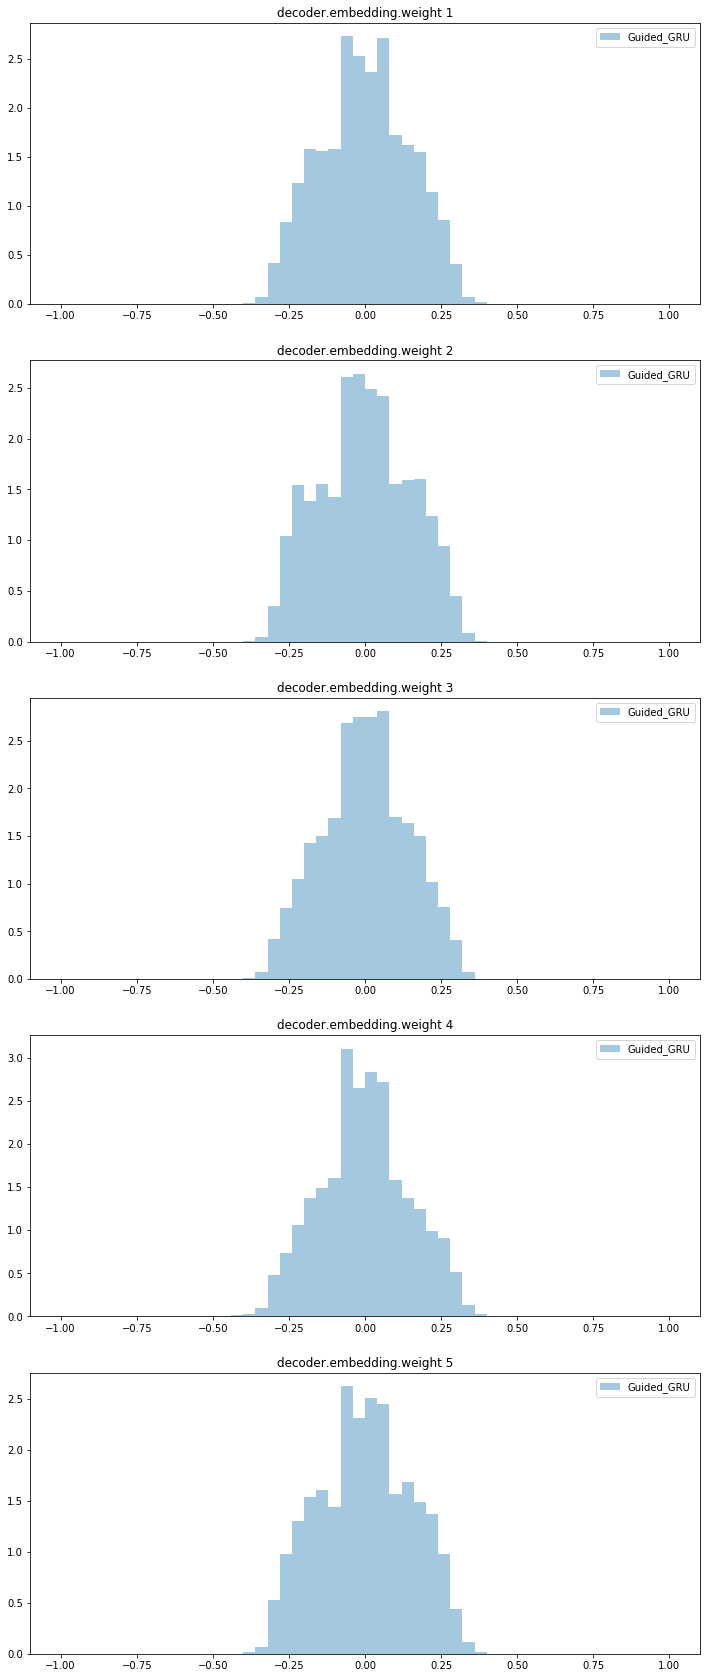

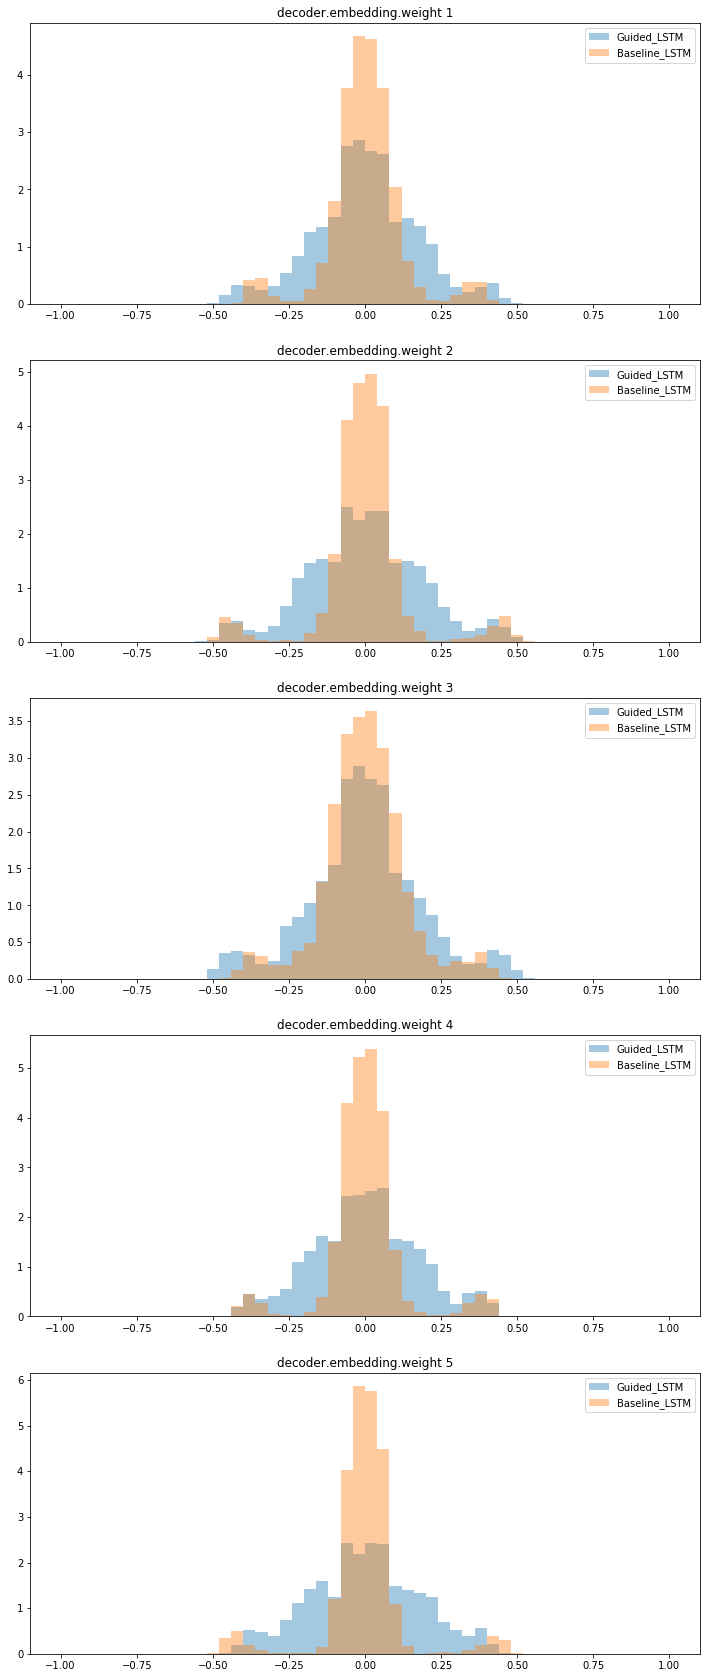

In [1647]:
analysis_GRU.plot_dist('decoder.embedding.weight')
analysis_LSTM.plot_dist('decoder.embedding.weight')

## Generate Heatmaps

In [845]:
baseline_lstm.apply_heatmap()
guided_lstm.apply_heatmap()
baseline_gru.apply_heatmap()
guided_gru.apply_heatmap()

/Users/davidrau/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


### MLP Classifier on weight columns

In [1621]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


def classify(models_base, models_gui, param):
    X = []
    y = []
    ## fill guided
    for i in range(1,6):
        data = models_base.models[str(i)].params[param]
        for i in range(data.shape[0]):
            X.append(data.iloc[i])
            y.append('baseline')
    
    # fill baseline        
    for i in range(1,6):
        data = models_gui.models[str(i)].params[param]
        for i in range(data.shape[0]):
            X.append(data.iloc[i])
            y.append('gru')   
    X = np.asarray(X)
    y = np.asarray(y)
    print('shape X:', X.shape)
    print('shape y:', y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    scaler = StandardScaler()

    # Fit only to the training data
    scaler.fit(X_train)

    # Now apply the transformations to the data:
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    mlp = MLPClassifier(hidden_layer_sizes=(13,13,13), activation='relu', solver='adam', max_iter=10000, early_stopping=True)

    mlp.fit(X_train,y_train)

    predictions = mlp.predict(X_test)

    print(classification_report(y_test,predictions))

In [1631]:
classify(baseline_gru, guided_gru, 'decoder.embedding.weight')

shape X: (110, 512)
shape y: (110,)
             precision    recall  f1-score   support

   baseline       0.68      0.79      0.73        19
        gru       0.73      0.61      0.67        18

avg / total       0.71      0.70      0.70        37



In [1623]:
for param in baseline_gru.models['1'].params.keys():
    print('Classifying on parameter', param)
    classify(baseline_lstm, guided_lstm, param)

Classifying on parameter encoder.embedding.weight
shape X: (190, 16)
shape y: (190,)
             precision    recall  f1-score   support

   baseline       0.41      0.48      0.44        31
        gru       0.38      0.31      0.34        32

avg / total       0.39      0.40      0.39        63

Classifying on parameter encoder.rnn.weight_ih_l0
shape X: (20480, 16)
shape y: (20480,)
             precision    recall  f1-score   support

   baseline       0.86      0.82      0.84      3404
        gru       0.83      0.87      0.85      3355

avg / total       0.85      0.84      0.84      6759

Classifying on parameter encoder.rnn.weight_hh_l0
shape X: (20480, 512)
shape y: (20480,)
             precision    recall  f1-score   support

   baseline       0.98      0.97      0.97      3404
        gru       0.97      0.98      0.97      3355

avg / total       0.97      0.97      0.97      6759

Classifying on parameter encoder.rnn.bias_ih_l0
shape X: (20480, 1)
shape y: (20480,)
     

/Users/davidrau/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



shape X: (110, 1)
shape y: (110,)
             precision    recall  f1-score   support

   baseline       0.51      1.00      0.68        19
        gru       0.00      0.00      0.00        18

avg / total       0.26      0.51      0.35        37

Classifying on parameter decoder.ffocus_merge.weight
shape X: (5120, 1024)
shape y: (5120,)
             precision    recall  f1-score   support

   baseline       0.97      0.95      0.96       874
        gru       0.94      0.97      0.96       816

avg / total       0.96      0.96      0.96      1690

Classifying on parameter decoder.ffocus_merge.bias
shape X: (5120, 1)
shape y: (5120,)
             precision    recall  f1-score   support

   baseline       0.56      0.56      0.56       874
        gru       0.53      0.53      0.53       816

avg / total       0.54      0.54      0.54      1690



In [1632]:
for param in baseline_gru.models['1'].params.keys():
    print('Classifying on parameter', param)
    classify(baseline_gru, guided_gru, param)

Classifying on parameter encoder.embedding.weight
shape X: (190, 16)
shape y: (190,)
             precision    recall  f1-score   support

   baseline       1.00      0.03      0.06        31
        gru       0.52      1.00      0.68        32

avg / total       0.75      0.52      0.38        63

Classifying on parameter encoder.rnn.weight_ih_l0
shape X: (15360, 16)
shape y: (15360,)
             precision    recall  f1-score   support

   baseline       0.89      0.82      0.85      2532
        gru       0.83      0.90      0.86      2537

avg / total       0.86      0.86      0.85      5069

Classifying on parameter encoder.rnn.weight_hh_l0
shape X: (15360, 512)
shape y: (15360,)
             precision    recall  f1-score   support

   baseline       0.96      0.95      0.96      2532
        gru       0.95      0.96      0.96      2537

avg / total       0.96      0.96      0.96      5069

Classifying on parameter encoder.rnn.bias_ih_l0
shape X: (15360, 1)
shape y: (15360,)
     

/Users/davidrau/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



shape X: (110, 512)
shape y: (110,)
             precision    recall  f1-score   support

   baseline       0.00      0.00      0.00        19
        gru       0.49      1.00      0.65        18

avg / total       0.24      0.49      0.32        37

Classifying on parameter decoder.attention.method.mlp.weight
shape X: (5120, 1024)
shape y: (5120,)
             precision    recall  f1-score   support

   baseline       0.96      0.94      0.95       874
        gru       0.94      0.96      0.95       816

avg / total       0.95      0.95      0.95      1690

Classifying on parameter decoder.attention.method.mlp.bias
shape X: (5120, 1)
shape y: (5120,)
             precision    recall  f1-score   support

   baseline       0.61      0.34      0.44       874
        gru       0.52      0.76      0.62       816

avg / total       0.57      0.55      0.53      1690

Classifying on parameter decoder.attention.method.out.weight
shape X: (10, 512)
shape y: (10,)
             precision    re

error: OpenCV(3.4.1) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/histogram.cpp:1498: error: (-210)  in function calcHist
